# Getting Dataset




In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download paultimothymooney/breast-histopathology-images

100% 3.08G/3.10G [00:59<00:00, 100MB/s] 
100% 3.10G/3.10G [00:59<00:00, 56.0MB/s]


In [ ]:
!mkdir DatasetFolder

In [ ]:
! unzip breast-histopathology-images.zip -d DatasetFolder > /dev/null 2>&1

# Loading Data




*   Resize Images and Convert to RGB
*   Add images to X array and labels to y array
*   Perform One-Hot-Encoding on y
*   Plot histogram for y




In [ ]:
import os 
import os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image



def makeList(path_ , subset_ , label_ , count_p , count_n ):
  X_ = []
  y_ = []
  for im in os.listdir(osp.join(path_ , subset_ , label_)):
    if label_ == '1':
      if count_p > SIZE : # we want to have the same number of IDC+ and IDC- to ensure model learn both well
        continue
      else:
        count_p+=1
    
    if label_ == '0':
      if count_n > SIZE : 
        continue
      else:
        count_n+=1
    image = Image.open(osp.join(path_ , subset_ ,label_ , im))
    image = image.convert('RGB')
    image = image.resize((50,50)) # images are 50x50 by default and colored but this just incase
    X_.append(image)
    y_.append(label_)

  return X_ , y_ , count_p , count_n





path = 'DatasetFolder'
SIZE = 19999
X = []
y = []
countP = 0
countN = 0

for subset in os.listdir(path):
  try:
    int(subset) # this line will make sure the weird file does not enter the the processing
    for label in os.listdir(osp.join(path , subset)):
      if countN > SIZE and label == '0':
        continue 
      if countP > SIZE and label == '1':
        continue 
      X_out , y_out , countP , countN = makeList(path , subset , label , countP , countN)
      X.extend(X_out)
      y.extend(y_out)

  except ValueError:
    # i did this because there is some weird file name
    pass






In [ ]:
X = [np.asarray(image) for image in X]
X = np.array(X)
y = np.array(y)
y = y.astype(np.int) # it saves it as strings i have to change it to int
print("X shape",X.shape, "y shape",y.shape)
# 277,524 same number as in dataset , 50x50 size , 3 for RGB


X shape (40000, 50, 50, 3) y shape (40000,)


(array([20000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 20000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

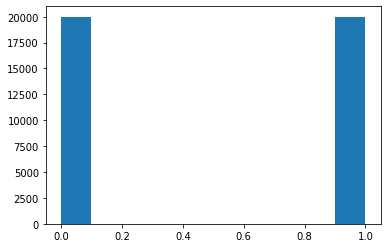

In [ ]:
plt.hist(y)

# Cool Data Images


Display random IDC+ and IDC- images for vizualization





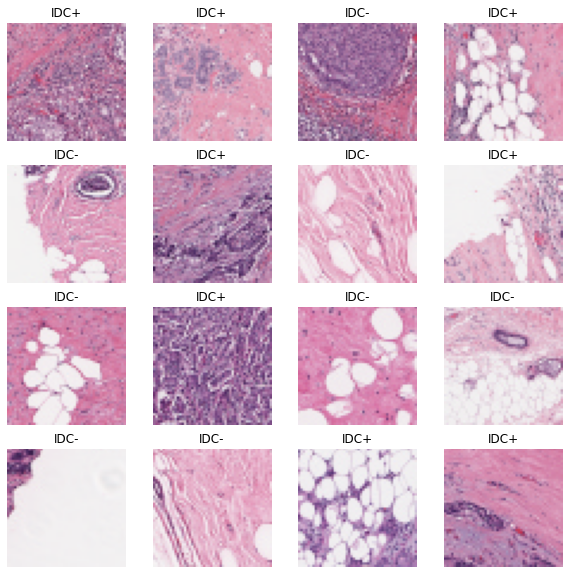

In [ ]:
plt.figure(figsize=(10,10))
from random import randint
for i in range(16):
  title = 'IDC+'
  ax = plt.subplot(4,4,i+1)
  ax.axis('off')
  rando = randint(0,X.shape[0])
  if y[rando]==0:
    title = 'IDC-'
  ax.title.set_text(title)
  ax.imshow(X[rando])

plt.show()

# Model Training 

In [ ]:
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report

Xtrain , Xtest , ytrain , ytest = tts(X, y , test_size=0.3, random_state=5)


import gc
del X
del y
del countN
del countP
del SIZE
del path
gc.collect()

30346

In [ ]:
Xtrain = Xtrain/255

In [ ]:
Xtest = Xtest/255

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.regularizers import l2

In [ ]:
clear_session()

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same' , activation='relu',kernel_regularizer = l2(0.001), input_shape=(50,50,3)))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same',kernel_regularizer = l2(0.001) , activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding = 'same',kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding = 'same',kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))

model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 128)       0

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(Xtrain,ytrain,epochs=50,validation_split=0.2)


Epoch 1/50
700/700 [==============================] - 26s 19ms/step - loss: 0.5236 - accuracy: 0.7913 - val_loss: 0.4277 - val_accuracy: 0.8263
Epoch 2/50
700/700 [==============================] - 13s 18ms/step - loss: 0.4181 - accuracy: 0.8338 - val_loss: 0.3923 - val_accuracy: 0.8400
Epoch 3/50
700/700 [==============================] - 13s 19ms/step - loss: 0.4004 - accuracy: 0.8397 - val_loss: 0.3976 - val_accuracy: 0.8414
Epoch 4/50
700/700 [==============================] - 13s 19ms/step - loss: 0.4011 - accuracy: 0.8372 - val_loss: 0.3796 - val_accuracy: 0.8464
Epoch 5/50
700/700 [==============================] - 13s 19ms/step - loss: 0.3944 - accuracy: 0.8403 - val_loss: 0.4092 - val_accuracy: 0.8386
Epoch 6/50
700/700 [==============================] - 13s 18ms/step - loss: 0.3910 - accuracy: 0.8422 - val_loss: 0.3893 - val_accuracy: 0.8475
Epoch 7/50
700/700 [==============================] - 13s 18ms/step - loss: 0.3884 - accuracy: 0.8417 - val_loss: 0.3755 - val_accuracy:

In [ ]:
loss, accuracy = model.evaluate(Xtest,ytest,verbose = 0)
accuracy = 100*round(accuracy,3)
print('The test accuracy is {} %'.format(accuracy))

The test accuracy is 85.7 %


# Model Evaluation


*   Plot the accuracy curves for training and validation
*   Plot the loss curves for training and validation






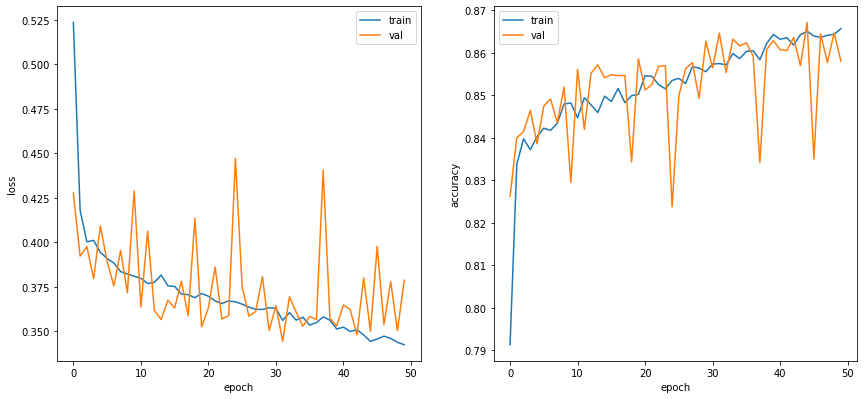

In [ ]:
plt.figure(figsize=(30,30))
ax = plt.subplot(4,4 ,1)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['train', 'val'])
ax = plt.subplot(4,4 , 2)
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend(['train', 'val'])
plt.show()

In [ ]:
ypred = model.predict(Xtest)
ypred = np.round(ypred)
ypred = ypred.astype(int)
print(classification_report(y_pred=ypred, y_true=ytest))

X = Xtest[900]
X = X[np.newaxis, ...]
y = int(ytest[900])

pred = model.predict(X)
if pred<0.5:
  pred = 0
else:
  pred = 1
print(pred, y)




              precision    recall  f1-score   support

           0       0.89      0.81      0.85      5930
           1       0.83      0.91      0.87      6070

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000

1 1


In [ ]:
Xtest[100].shape

(50, 50, 3)

# Logistic Regression Model 

In [ ]:
from sklearn.linear_model import LogisticRegression
vector = 50*50*3
newXtrain = Xtrain.reshape(Xtrain.shape[0],vector)
newXtest = Xtest.reshape(Xtest.shape[0],vector)

In [ ]:
logReg = LogisticRegression()
logReg.fit(newXtrain , ytrain)
yPred = logReg.predict(newXtest)
print(classification_report(yPred, ytest))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76      6348
           1       0.72      0.78      0.75      5652

    accuracy                           0.76     12000
   macro avg       0.76      0.76      0.76     12000
weighted avg       0.76      0.76      0.76     12000



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


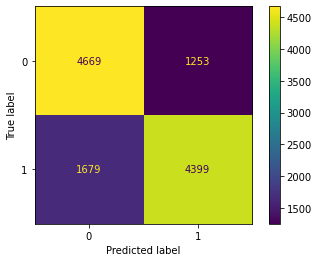

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logReg, newXtest, ytest)  
plt.show()

#SVC Model

In [ ]:
from sklearn.svm import SVC
vector = 50*50*3
newXtrain = Xtrain.reshape(Xtrain.shape[0],vector)
newXtest = Xtest.reshape(Xtest.shape[0],vector)

In [ ]:
svc = SVC()
svc.fit(newXtrain , ytrain)
yPred = svc.predict(newXtest)
print(classification_report(yPred, ytest))

              precision    recall  f1-score   support

           0       0.92      0.80      0.85       688
           1       0.77      0.91      0.83       512

    accuracy                           0.84      1200
   macro avg       0.84      0.85      0.84      1200
weighted avg       0.86      0.84      0.85      1200



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


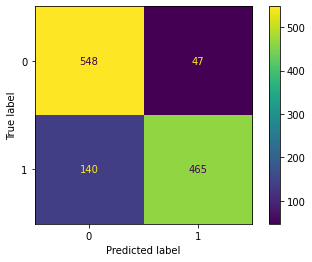

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(svc, newXtest, ytest)  
plt.show()

#Random Forest Classifier Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf=RandomForestClassifier(n_estimators=100)

nsamples, nx, ny, nz = Xtrain.shape
d2_Xtrain = Xtrain.reshape((nsamples,nx*ny*nz))
clf.fit(d2_Xtrain,ytrain)

nTsamples, nTx, nTy, nTz = Xtest.shape
d2_Xtest = Xtest.reshape((nTsamples,nTx*nTy*nTz))

ypred=clf.predict(d2_Xtest)

from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(ytest, ypred))
print(classification_report(ypred, ytest))

Accuracy: 0.8226666666666667
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      6114
           1       0.81      0.84      0.82      5886

    accuracy                           0.82     12000
   macro avg       0.82      0.82      0.82     12000
weighted avg       0.82      0.82      0.82     12000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


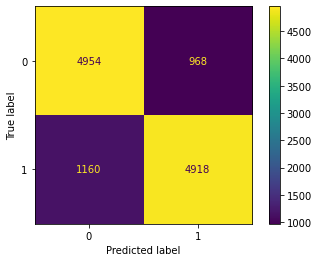

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, d2_Xtest, ytest)  
plt.show()